In [1]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt

In [2]:
!pip install pytorch_memlab

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from Boosting import Ensemble, runBoosting
from AdversarialAttacks import attack_fgsm, attack_pgd
from pytorch_memlab import LineProfiler

In [4]:
import utils

In [5]:
cuda = torch.device('cuda:0')

In [6]:
%load_ext autoreload
%autoreload 2

## CIFAR10 Boosting (Adversarial)

In [7]:
maxSamples_vals = [10000, 50000, 100000, 200000, 500000]
# maxSamples_vals = [50000]
batch_size=100
maxSamples_vals = [batch_size + 1]

In [8]:
num_wl = 20 # maybe around 100? #later: maybe change this to an array?
num_epochs = 1

In [9]:
ensembles = []
epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]
# epsilons = [0.0, 0.01]

In [10]:
# from Boosting import SchapireWongMulticlassBoosting
# from AdversarialAttacks import attack_fgsm
# # Ensemble.record_accuracies, Ensemble.calc_accuracies, attack_fgsm, Ensemble.schapireContinuousPredict
# with LineProfiler(runBoosting, SchapireWongMulticlassBoosting, WongNeuralNetCIFAR10.fit, WongNeuralNetCIFAR10.batchUpdate) as prof:
#     for i in range(len(maxSamples_vals)):
#         maxSamples = maxSamples_vals[i]
#         ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [attack_fgsm], 
#                                    attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=8, adv_train=True, batch_size=batch_size)
#         ensembles.append(ensemble)
#         path_head = 'results/plots/cifar10/'
#         acc_file = path_head + f'acc_maxSamples_{maxSamples}.png'
#         adv_acc_file = path_head + f'adv_acc_maxSamples_{maxSamples}.png'
#         loss_file = path_head + f'loss_maxSamples_{maxSamples}.png'
#         wl_train_acc_file = path_head + f'wl_train_acc_maxSamples_{maxSamples}.png'
#         ensemble.plot_accuracies(acc_file)
#         ensemble.plot_loss(loss_file)
#         ensemble.plot_adversarial_accuracies(adv_acc_file)
#         ensemble.plot_wl_train_acc(wl_train_acc_file)
# prof.display()

In [11]:
from Boosting import SchapireWongMulticlassBoosting
from AdversarialAttacks import attack_fgsm
import gc
# Ensemble.record_accuracies, Ensemble.calc_accuracies, attack_fgsm, Ensemble.schapireContinuousPredict
with LineProfiler(runBoosting, SchapireWongMulticlassBoosting, WongNeuralNetCIFAR10.fit, WongNeuralNetCIFAR10.batchUpdate) as prof:
    for i in range(len(maxSamples_vals)):
        maxSamples = maxSamples_vals[i]
        ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [], 
                                   attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=8, adv_train=True, batch_size=batch_size)
        ensembles.append(ensemble)
        gc.collect()
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    print(type(obj), obj.size())
            except:
                pass
        
#         path_head = 'results/plots/cifar10/'
#         acc_file = path_head + f'acc_maxSamples_{maxSamples}.png'
#         adv_acc_file = path_head + f'adv_acc_maxSamples_{maxSamples}.png'
#         loss_file = path_head + f'loss_maxSamples_{maxSamples}.png'
#         wl_train_acc_file = path_head + f'wl_train_acc_maxSamples_{maxSamples}.png'
#         ensemble.plot_accuracies(acc_file)
#         ensemble.plot_loss(loss_file)
#         ensemble.plot_adversarial_accuracies(adv_acc_file)
#         ensemble.plot_wl_train_acc(wl_train_acc_file)
prof.display()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
attack eps ens [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]
----------------------------------------------------------------------------------------------------
Training weak learner 0
1 num references to our NN class:  3
1 num references to our NN class:  2
adv_train: True
Epoch 0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2 num references to our NN class:  3
2 num references to our NN class:  2
Training accuracy of weak learner:  0.1
Alpha:  0.0
3 num references to our NN class:  5
3 num references to our NN class:  4
4 num references to our NN class:  3
4 num references to our NN class:  3
t:  0 memory allocated: 137579520
Progress: 0,  val accuracy: 0.1000


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


<class 'torch.Tensor'> torch.Size([3, 1, 1])
<class 'torch.Tensor'> torch.Size([3, 1, 1])
<class 'torch.Tensor'> torch.Size([3, 1, 1])
<class 'torch.Tensor'> torch.Size([3, 1, 1])
<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([50000])
<class 'torch.Tensor'> torch.Size([10000])
<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100])
----------------------------------------------------------------------------------------------------
Training weak learner 1
1 num references to our NN class:  3
1 num references to our NN class:  2
adv_train: True
Epoch 0
2 num references to our NN class:  3
2 num references to our NN class:  2
Training accuracy of weak learner:  0.10472
Alpha:  0.00524449252

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 11.17 GiB total capacity; 10.66 GiB already allocated; 640.00 KiB free; 10.74 GiB reserved in total by PyTorch)

In [ ]:
# for maxSamples in maxSamples_vals:
#         ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [attack_fgsm], 
#                                attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=8, adv_train=True)
#         ensembles.append(ensemble)

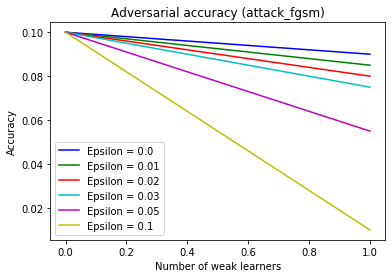

In [12]:
ensembles[0].plot_adversarial_accuracies()

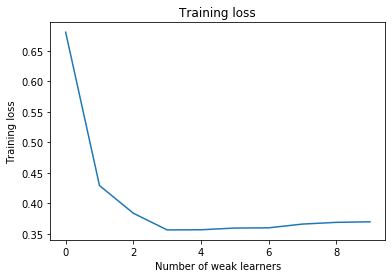

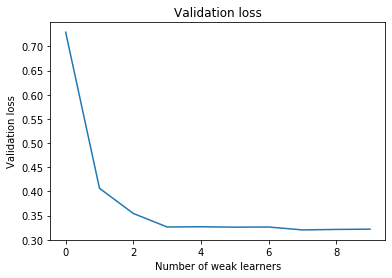

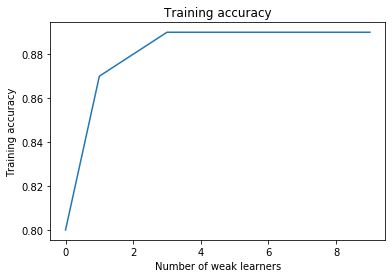

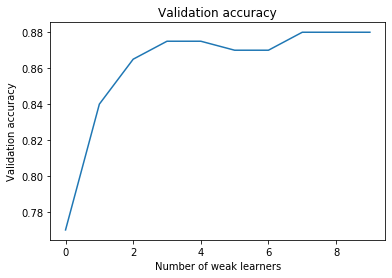

In [11]:
ensembles[0].plot_train_loss()
ensembles[0].plot_val_loss()
ensembles[0].plot_train_accuracies()
ensembles[0].plot_val_accuracies()

In [10]:
ensembles[0].attack_eps

[]